<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Chapter-21.-Class-Metaprogramming" data-toc-modified-id="Chapter-21.-Class-Metaprogramming-1">Chapter 21. Class Metaprogramming</a></span><ul class="toc-item"><li><span><a href="#Boilerplate-class-definition" data-toc-modified-id="Boilerplate-class-definition-1.1">Boilerplate class definition</a></span></li><li><span><a href="#Dynamic-class-definition" data-toc-modified-id="Dynamic-class-definition-1.2">Dynamic class definition</a></span></li><li><span><a href="#Class-Decorators" data-toc-modified-id="Class-Decorators-1.3">Class Decorators</a></span></li><li><span><a href="#runtime-order-for-classes,-subclasses-and-functions" data-toc-modified-id="runtime-order-for-classes,-subclasses-and-functions-1.4">runtime order for classes, subclasses and functions</a></span></li><li><span><a href="#import-time-execution-order-for-functions" data-toc-modified-id="import-time-execution-order-for-functions-1.5">import time execution order for functions</a></span></li><li><span><a href="#import-time-execution-time-for-classes,-subclasses" data-toc-modified-id="import-time-execution-time-for-classes,-subclasses-1.6">import time execution time for classes, subclasses</a></span></li><li><span><a href="#Metaclasses" data-toc-modified-id="Metaclasses-1.7">Metaclasses</a></span></li><li><span><a href="#The-Metaclass-__prepare__-Special-Method" data-toc-modified-id="The-Metaclass-__prepare__-Special-Method-1.8">The Metaclass <code>__prepare__</code> Special Method</a></span></li><li><span><a href="#Classes-as-Objects" data-toc-modified-id="Classes-as-Objects-1.9">Classes as Objects</a></span></li></ul></li></ul></div>

# Chapter 21. Class Metaprogramming
Class metaprogramming is the art of creating or customizing classes at runtime. Classes are first-class objects in Python, so a function can be used to create a new class at any time, without using the class keyword. Class decorators are also functions, but capable of inspecting, changing, and even replacing the decorated class with another class. Finally, metaclasses are the most advanced tool for class metaprogramming: they let you create whole new categories of classes with special traits, such as the abstract base classes we’ve already seen.


## Boilerplate class definition

In [229]:
class Dog:
    def __init__(self, name, weight, owner):
        self.name = name
        self.weight = weight
        self.owner = owner
        
rex = Dog('Rex', 30, 'Bob')
rex

## Dynamic class definition

In [243]:
def record_factory(cls_name, field_names):
    
    def __init__(self, *args, **kwargs):   
        attrs = dict(zip(self.__slots__, args))
        attrs.update(kwargs)
        for name, value in attrs.items():
            setattr(self, name, value)

    def __iter__(self):   
        for name in self.__slots__:
            yield getattr(self, name)

    def __repr__(self):   
        values = ', '.join('{}={!r}'.format(*i) for i
                           in zip(self.__slots__, self))
        return '{}({})'.format(self.__class__.__name__, values)

#     split field_names into iterable sequence
    try:
        field_names = field_names.replace(',', ' ').split()   
    except AttributeError:  # no .replace or .split
        pass  # assume it's already a sequence of identifiers
    field_names = tuple(field_names) 

# Assemble dictionary of class attributes.
    cls_attrs = dict(__slots__ = field_names,   
                     __init__  = __init__,
                     __iter__  = __iter__,
                     __repr__  = __repr__)
    
# Build and return the new class, calling the type constructor.
    return type(cls_name, (object,), cls_attrs)   



In [244]:
Dog = record_factory('Dog', 'name weight owner')
rex = Dog('Rex', 30, 'Bob')
rex

Dog(name='Rex', weight=30, owner='Bob')

In [245]:
name, weight, _ = rex
name, weight

('Rex', 30)

In [246]:
"{2}'s dog weighs {1}kg".format(*rex)

"Bob's dog weighs 30kg"

In [247]:
rex.weight = 32
rex

Dog(name='Rex', weight=32, owner='Bob')

In [248]:
Dog.__mro__

(__main__.Dog, object)

The three arguments of `type()`are named name, bases, and dict—the latter being a mapping of attribute names and attributes for the new class. 

In [253]:
class MySuperClass: pass
class MyMixin: pass

MyClass = type('MyClass', (MySuperClass, MyMixin),
               {'x': 42, 'x2': lambda self: self.x * 2})
vars(MyClass)

mappingproxy({'x': 42,
              'x2': <function __main__.<lambda>(self)>,
              '__module__': '__main__',
              '__doc__': None})

In [254]:
mc = MyClass()
mc.x

42

In [256]:
mc.x2()

84

## Class Decorators
Class decorators are a simpler way of doing something that previously required a metaclass: customizing a class the moment it’s created.

In [264]:
# change the storage_name attribute of each descriptor instance
# to be for exammple, '_Quantity#weight' in decorator
def entity(cls):   
    for key, attr in cls.__dict__.items():   
        if isinstance(attr, Validated):   
            type_name = type(attr).__name__
            attr.storage_name = '_{}#{}'.format(type_name, key)   
    return cls   

@entity   
class LineItem:
    description = NonBlank()
    weight = Quantity()
    price = Quantity()

    def __init__(self, description, weight, price):
        self.description = description
        self.weight = weight
        self.price = price

    def subtotal(self):
        return self.weight * self.price


In [267]:
raisins = LineItem('Golden raisins', 10, 6.95)
dir(raisins)[:3]

['_NonBlank#description', '_Quantity#price', '_Quantity#weight']

In [268]:
LineItem.description.storage_name

'_NonBlank#description'

In [269]:
raisins.description

'Golden raisins'

In [270]:
getattr(raisins, '_NonBlank#description')

'Golden raisins'

## runtime order for classes, subclasses and functions

In [ ]:
#  restart kernel before running next cell
import os
os._exit(00)

In [1]:
from evalsupport import deco_alpha

print('<[1]> evaltime module start')


class ClassOne():
    print('<[2]> ClassOne body')

    def __init__(self):
        print('<[3]> ClassOne.__init__')

    def __del__(self):
        print('<[4]> ClassOne.__del__')

    def method_x(self):
        print('<[5]> ClassOne.method_x')

    class ClassTwo(object):
        print('<[6]> ClassTwo body')


@deco_alpha
class ClassThree():
    print('<[7]> ClassThree body')

    def method_y(self):
        print('<[8]> ClassThree.method_y')


class ClassFour(ClassThree): # subclasses ClassThree
    print('<[9]> ClassFour body')

    # the effects of a class decorator do not affect subclasses
    def method_y(self):
        print('<[10]> ClassFour.method_y')


if __name__ == '__main__':
    print('<[11]> ClassOne tests', 30 * '.')
    one = ClassOne()
    one.method_x()
    print('<[12]> ClassThree tests', 30 * '.')
    three = ClassThree()
    three.method_y()
    print('<[13]> ClassFour tests', 30 * '.')
    four = ClassFour()
    four.method_y()


print('<[14]> evaltime module end')

<[100]> evalsupport module start
<[400]> MetaAleph body
<[700]> evalsupport module end
<[1]> evaltime module start
<[2]> ClassOne body
<[6]> ClassTwo body
<[7]> ClassThree body
<[200]> deco_alpha
<[9]> ClassFour body
<[11]> ClassOne tests ..............................
<[3]> ClassOne.__init__
<[5]> ClassOne.method_x
<[12]> ClassThree tests ..............................
<[300]> deco_alpha:inner_1
<[13]> ClassFour tests ..............................
<[10]> ClassFour.method_y
<[14]> evaltime module end


## import time execution order for functions
* excutes `def` statement
* compiles the function body
* bind function object to its global name
* does not execute the body of the function

## import time execution time for classes, subclasses
* attributes and method of the class are defined
* executes the body of the class and any nested classes
* class object is built

In [ ]:
#  restart kernel before running next cell
import os
os._exit(00)

In [1]:
import evaltime

<[100]> evalsupport module start
<[400]> MetaAleph body
<[700]> evalsupport module end
<[1]> evaltime module start
<[2]> ClassOne body
<[6]> ClassTwo body
<[7]> ClassThree body
<[200]> deco_alpha
<[9]> ClassFour body
<[14]> evaltime module end


## Metaclasses
In the real world, metaclasses are used in frameworks and libraries that help programmers perform, among other tasks:
* Attribute validation
* Applying decorators to many methods at once
* Object serialization or data conversion
* Object-relational mapping
* Object-based persistency
* Dynamic translation of class structures from other languages

By default, Python classes are instances of type. In other words, type is the metaclass for most built-in and user-defined classes:

In [4]:
'spam'.__class__

str

In [5]:
str.__class__

type

In [6]:
type.__class__

type

`object` is an instance of `type`, and `type` is a subclass of `object`

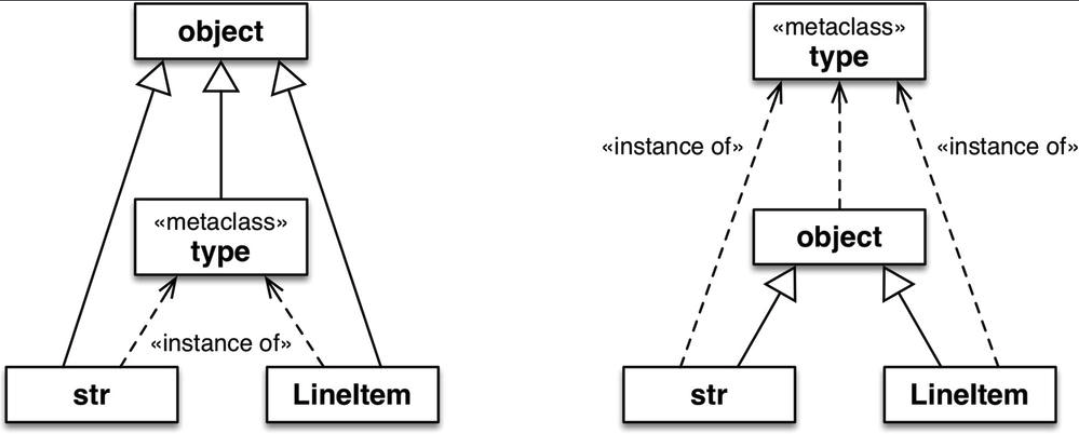

In [7]:
from IPython.display import Image
Image(filename = "type.png")

Every class is an instance of `type`, directly or indirectly, but only metaclasses are also subclasses of `type`. That’s the most important relationship to understand metaclasses: a metaclass, such as `ABCMeta`, inherits from `type` the power to construct classes.

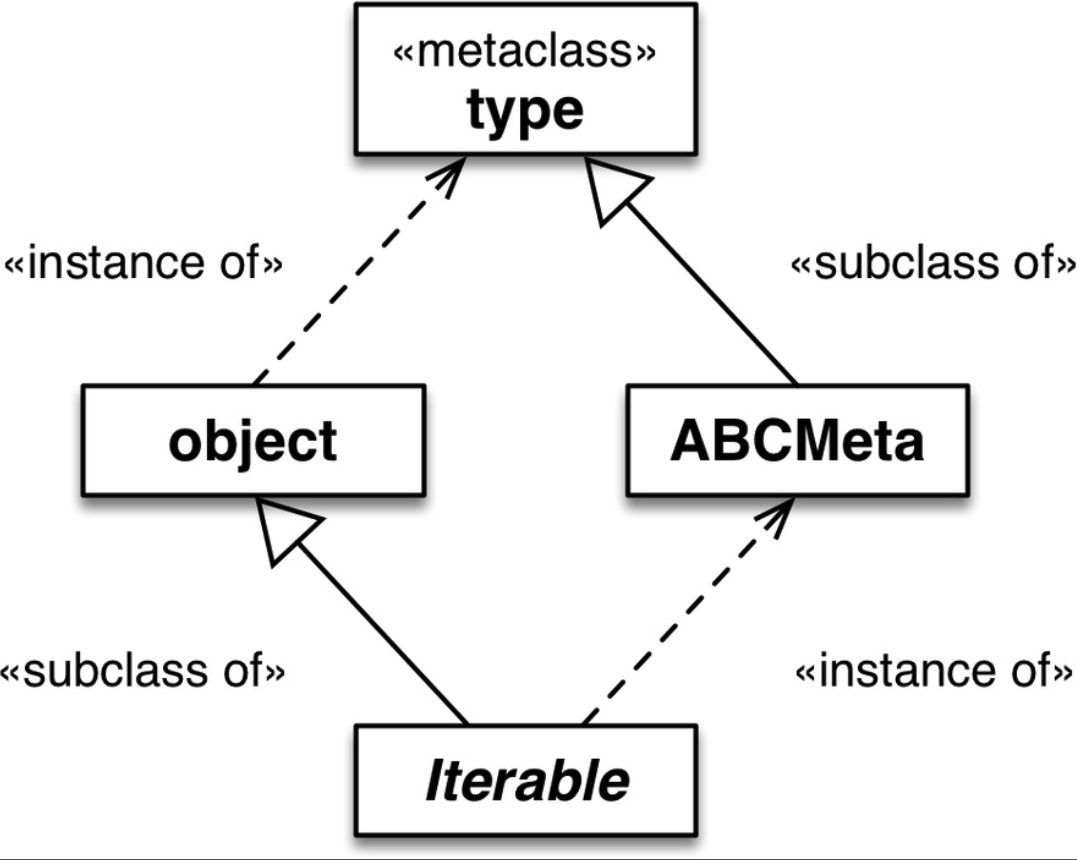

In [1]:
from IPython.display import Image
Image(filename = "type2.png")

In [2]:
from evalsupport import deco_alpha
from evalsupport import MetaAleph

print('<[1]> evaltime_meta module start')


@deco_alpha
class ClassThree():
    print('<[2]> ClassThree body')

    def method_y(self):
        print('<[3]> ClassThree.method_y')


class ClassFour(ClassThree):
    print('<[4]> ClassFour body')

    def method_y(self):
        print('<[5]> ClassFour.method_y')


class ClassFive(metaclass=MetaAleph):
    print('<[6]> ClassFive body')

    def __init__(self):
        print('<[7]> ClassFive.__init__')

    def method_z(self):
        print('<[8]> ClassFive.method_y')

class ClassSix(ClassFive):
    print('<[9]> ClassSix body')

    def method_z(self):
        print('<[10]> ClassSix.method_y')


if __name__ == '__main__':
    print('<[11]> ClassThree tests', 30 * '.')
    three = ClassThree()
    three.method_y()
    print('<[12]> ClassFour tests', 30 * '.')
    four = ClassFour()
    four.method_y()
    print('<[13]> ClassFive tests', 30 * '.')
    five = ClassFive()
    five.method_z()
    print('<[14]> ClassSix tests', 30 * '.')
    six = ClassSix()
    six.method_z()

print('<[15]> evaltime_meta module end')

<[100]> evalsupport module start
<[400]> MetaAleph body
<[700]> evalsupport module end
<[1]> evaltime_meta module start
<[2]> ClassThree body
<[200]> deco_alpha
<[4]> ClassFour body
<[6]> ClassFive body
<[500]> MetaAleph.__init__
<[9]> ClassSix body
<[500]> MetaAleph.__init__
<[11]> ClassThree tests ..............................
<[300]> deco_alpha:inner_1
<[12]> ClassFour tests ..............................
<[5]> ClassFour.method_y
<[13]> ClassFive tests ..............................
<[7]> ClassFive.__init__
<[600]> MetaAleph.__init__:inner_2
<[14]> ClassSix tests ..............................
<[7]> ClassFive.__init__
<[600]> MetaAleph.__init__:inner_2
<[15]> evaltime_meta module end


In [ ]:
#  restart kernel before running next cell
import os
os._exit(00)

In [1]:
from evalsupport import deco_alpha
from evalsupport import MetaAleph

print('<[1]> evaltime_meta module start')


@deco_alpha
class ClassThree():
    print('<[2]> ClassThree body')

    def method_y(self):
        print('<[3]> ClassThree.method_y')


class ClassFour(ClassThree):
    print('<[4]> ClassFour body')

    def method_y(self):
        print('<[5]> ClassFour.method_y')


class ClassFive(metaclass=MetaAleph):
    print('<[6]> ClassFive body')

    def __init__(self):
        print('<[7]> ClassFive.__init__')

    def method_z(self):
        print('<[8]> ClassFive.method_y')
        
        
class ClassSix(ClassFive):
    print('<[9]> ClassSix body')

    def method_z(self):
        print('<[10]> ClassSix.method_y')


if __name__ == '__main__':
    print('<[11]> ClassThree tests', 30 * '.')
    three = ClassThree()
    three.method_y()
    print('<[12]> ClassFour tests', 30 * '.')
    four = ClassFour()
    four.method_y()
    print('<[13]> ClassFive tests', 30 * '.')
    five = ClassFive()
    five.method_z()
    print('<[14]> ClassSix tests', 30 * '.')
    six = ClassSix()
    six.method_z()
    
print('<[15]> evaltime_meta module end')

<[100]> evalsupport module start
<[400]> MetaAleph body
<[700]> evalsupport module end
<[1]> evaltime_meta module start
<[2]> ClassThree body
<[200]> deco_alpha
<[4]> ClassFour body
<[6]> ClassFive body
<[500]> MetaAleph.__init__
<[9]> ClassSix body
<[500]> MetaAleph.__init__
<[11]> ClassThree tests ..............................
<[300]> deco_alpha:inner_1
<[12]> ClassFour tests ..............................
<[5]> ClassFour.method_y
<[13]> ClassFive tests ..............................
<[7]> ClassFive.__init__
<[600]> MetaAleph.__init__:inner_2
<[14]> ClassSix tests ..............................
<[7]> ClassFive.__init__
<[600]> MetaAleph.__init__:inner_2
<[15]> evaltime_meta module end


In [ ]:
#  restart kernel before running next cell
import os
os._exit(00)

In [1]:
import evaltime_meta

<[100]> evalsupport module start
<[400]> MetaAleph body
<[700]> evalsupport module end
<[1]> evaltime_meta module start
<[2]> ClassThree body
<[200]> deco_alpha
<[4]> ClassFour body
<[6]> ClassFive body
<[500]> MetaAleph.__init__
<[9]> ClassSix body
<[500]> MetaAleph.__init__
<[15]> evaltime_meta module end


## The Metaclass `__prepare__` Special Method
The type constructor and the `__new__` and `__init__` methods of metaclasses receive the body of the class evaluated as a mapping of names to attributes. However, by default, that mapping is a dict, which means the order of the attributes as they appear in the class body is lost by the time our metaclass or class decorator can look at them.
The solution to this problem is the `__prepare__` special method, introduced in Python 3.

In [8]:
from collections import OrderedDict
import abc

class AutoStorage:   
    __counter = 0

    def __init__(self):
        cls = self.__class__
        prefix = cls.__name__
        index = cls.__counter
        self.storage_name = '_{}#{}'.format(prefix, index)
        cls.__counter += 1

    def __get__(self, instance, owner):
        if instance is None:
            return self
        else:
            return getattr(instance, self.storage_name)

    def __set__(self, instance, value):
        setattr(instance, self.storage_name, value)   


class Validated(abc.ABC, AutoStorage):   

    def __set__(self, instance, value):
        value = self.validate(instance, value)   
        super().__set__(instance, value)   

    @abc.abstractmethod
    def validate(self, instance, value):   
        """return validated value or raise ValueError"""


class EntityMeta(type):
    """Metaclass for business entities with validated fields"""

# Return an empty OrderedDict instance, 
# where the class attributes will be stored.
    @classmethod
    def __prepare__(cls, name, bases):
        return OrderedDict()   

    def __init__(cls, name, bases, attr_dict):
        super().__init__(name, bases, attr_dict)
        cls._field_names = []   
        for key, attr in attr_dict.items():   
            if isinstance(attr, Validated):
                type_name = type(attr).__name__
                attr.storage_name = '_{}#{}'.format(type_name, key)
                cls._field_names.append(key)   


class Entity(metaclass=EntityMeta):
    """Business entity with validated fields"""

    @classmethod
    def field_names(cls):   
        for name in cls._field_names:
            yield name

## Classes as Objects

Three of  attributes we’ve seen already: `__mro__`, `__class__`, and `__name__`. Other class attributes are:

* `cls.__bases__`
   
   The tuple of base classes of the class.


* `cls.__qualname__`

   The qualified name of a class or function, which is a dotted path from the global scope of the module to the class definition.
  
  
* `cls.__subclasses__()`

   The method returns the list of subclasses that currently exist in memory.
   
   
* `cls.mro()`

   The interpreter calls this method when building a class to obtain the tuple of superclasses that is stored in the __mro__ attribute of the class. 